# Proyecto de reconocimiento de aves usando una Red Neuronal Convolucional (CNN)
Miguel Sebastian Navarro Islas

## Dependencias

In [ ]:
import os
import numpy             as np
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import tensorflow        as tf
from matplotlib.pyplot import imshow
from sklearn.metrics   import confusion_matrix, roc_curve, classification_report
from tensorflow        import keras
from keras.models      import Sequential, Model
from keras.utils       import image_dataset_from_directory
from keras.layers      import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Obtención del Dataset

El dataset consiste de 89,895 imagenes de aves de 525 especies distintas. Estas imagenes vienen separadas en tres directorios, uno para entrenamiento, uno para pruebas y uno para validación. El objetivo de esta sección es obtener las imagenes y prepararlas para un entrenamiento de una red neuronal.

In [ ]:
!cp '/content/drive/My Drive/birbs/train' 'train' -r

In [ ]:
!cp '/content/drive/My Drive/birbs/test' 'test' -r

In [ ]:
!cp '/content/drive/My Drive/birbs/valid' 'valid' -r

In [16]:
training_directory = 'train'
test_directory = 'test'
validation_directory = 'valid'
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [17]:
train_data_generator = ImageDataGenerator(rescale=1/255.)
val_datagenerator = ImageDataGenerator(rescale=1/255.)
test_datagenerator = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_dataset = train_data_generator.flow_from_directory(training_directory,
                                                         target_size = IMG_SIZE,
                                                         batch_size = 32,
                                                         shuffle = True,
                                                         class_mode = "categorical")

Found 84631 images belonging to 525 classes.


In [ ]:
validation_dataset = val_datagenerator.flow_from_directory(validation_directory,
                                                         target_size = IMG_SIZE,
                                                         batch_size = 32,
                                                         shuffle = False,
                                                         class_mode = "categorical")

Found 2625 images belonging to 525 classes.


In [18]:
test_dataset = test_datagenerator.flow_from_directory(test_directory,
                                                         target_size = IMG_SIZE,
                                                         batch_size = 32,
                                                         shuffle = False,
                                                         class_mode = "categorical")

Found 2625 images belonging to 525 classes.


## Entrenamiento
Para facilitar el entrenamiento y obtener mejores resultados, se utiliza una red preentrenada. Para ser especificos, se utiliza la red MobileNetV2.

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
inputs = tf.keras.Input(shape=IMG_SHAPE) 
base = MobileNetV2(include_top = False, input_tensor = inputs)
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(525, activation = "softmax")(x)
model = Model(inputs = inputs, outputs= x)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

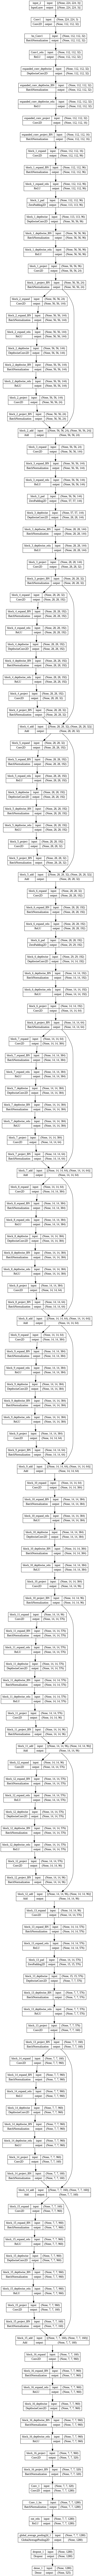

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
base_learning_rate = 0.0001
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss      = tf.keras.losses.categorical_crossentropy,
    metrics   = ['accuracy']
)

In [ ]:
%time history_MobileNetV2 = model.fit( train_dataset, validation_data=validation_dataset,  epochs = 5)

Epoch 1/5
2645/2645 [==============================] - 415s 142ms/step - loss: 0.2707 - accuracy: 0.9264 - val_loss: 0.1585 - val_accuracy: 0.9566
Epoch 2/5
2645/2645 [==============================] - 369s 140ms/step - loss: 0.1953 - accuracy: 0.9456 - val_loss: 0.1417 - val_accuracy: 0.9600
Epoch 3/5
2645/2645 [==============================] - 374s 141ms/step - loss: 0.1547 - accuracy: 0.9562 - val_loss: 0.1395 - val_accuracy: 0.9627
Epoch 4/5
2645/2645 [==============================] - 372s 141ms/step - loss: 0.1273 - accuracy: 0.9624 - val_loss: 0.1285 - val_accuracy: 0.9642
Epoch 5/5
2645/2645 [==============================] - 371s 140ms/step - loss: 0.1055 - accuracy: 0.9695 - val_loss: 0.1271 - val_accuracy: 0.9638
CPU times: user 39min 38s, sys: 1min 19s, total: 40min 58s
Wall time: 31min 52s


## Gráficas

In [ ]:
acc =  [0.] + history_MobileNetV2.history['accuracy']
val_acc =  [0.] + history_MobileNetV2.history['val_accuracy']

loss = [ np.max(history_MobileNetV2.history['loss']) ] + history_MobileNetV2.history['loss']
val_loss = [ np.max(history_MobileNetV2.history['val_loss']) ] + history_MobileNetV2.history['val_loss']

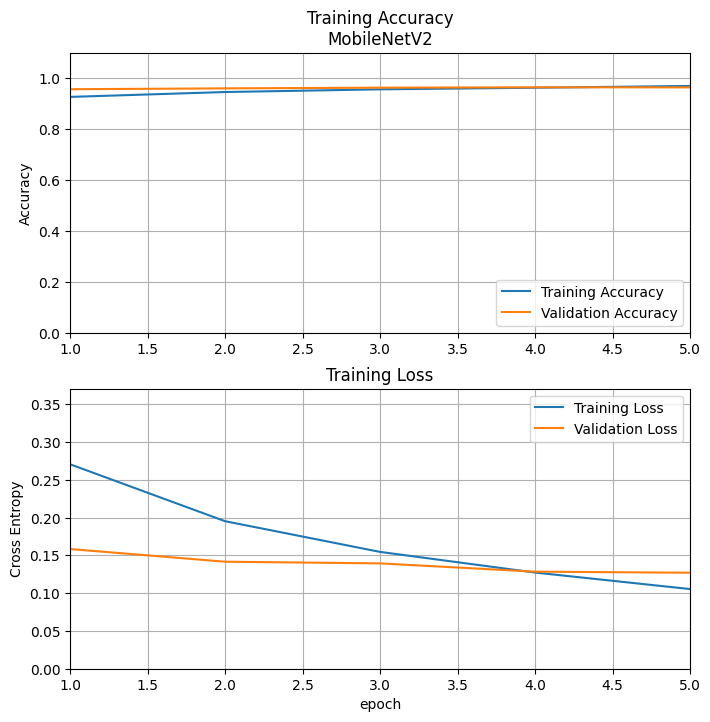

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlim([1,5])
plt.ylim([0,1.1])
plt.grid(True)
plt.title('Training Accuracy\nMobileNetV2')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlim([1,5])
max1 = np.max(loss)
max2 = np.max(val_loss)
plt.ylim([0, np.max([max1,max2])+0.1 ])
plt.grid(True)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

##  Evaluación

In [ ]:
Loss, Accuracy = model.evaluate(train_dataset)

print("    Train Loss: {:.5f}".format(Loss))
print("Train Accuracy: {:.2f}%".format(Accuracy * 100))

2645/2645 [==============================] - 236s 89ms/step - loss: 0.0294 - accuracy: 0.9930
    Train Loss: 0.02941
Train Accuracy: 99.30%


In [ ]:
Loss, Accuracy = model.evaluate(validation_dataset)

print("    Train Loss: {:.5f}".format(Loss))
print("Validation Accuracy: {:.2f}%".format(Accuracy * 100))

83/83 [==============================] - 7s 79ms/step - loss: 0.1271 - accuracy: 0.9638
    Train Loss: 0.12711
Validation Accuracy: 96.38%


In [ ]:
Loss, Accuracy = model.evaluate(test_dataset)

print("    Train Loss: {:.5f}".format(Loss))
print("Test Accuracy: {:.2f}%".format(Accuracy * 100))

83/83 [==============================] - 10s 118ms/step - loss: 0.0580 - accuracy: 0.9817
    Train Loss: 0.05798
Test Accuracy: 98.17%


In [ ]:
model.save('model.h5')

## Conversión

In [ ]:
!pip install tensorflowjs 

In [ ]:
!mkdir export

In [ ]:
!tensorflowjs_converter --input_format keras model.h5  export

2023-05-16 23:15:30.378802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Graficas bonitas y divertidas

525
1/1 [==============================] - 0s 27ms/step


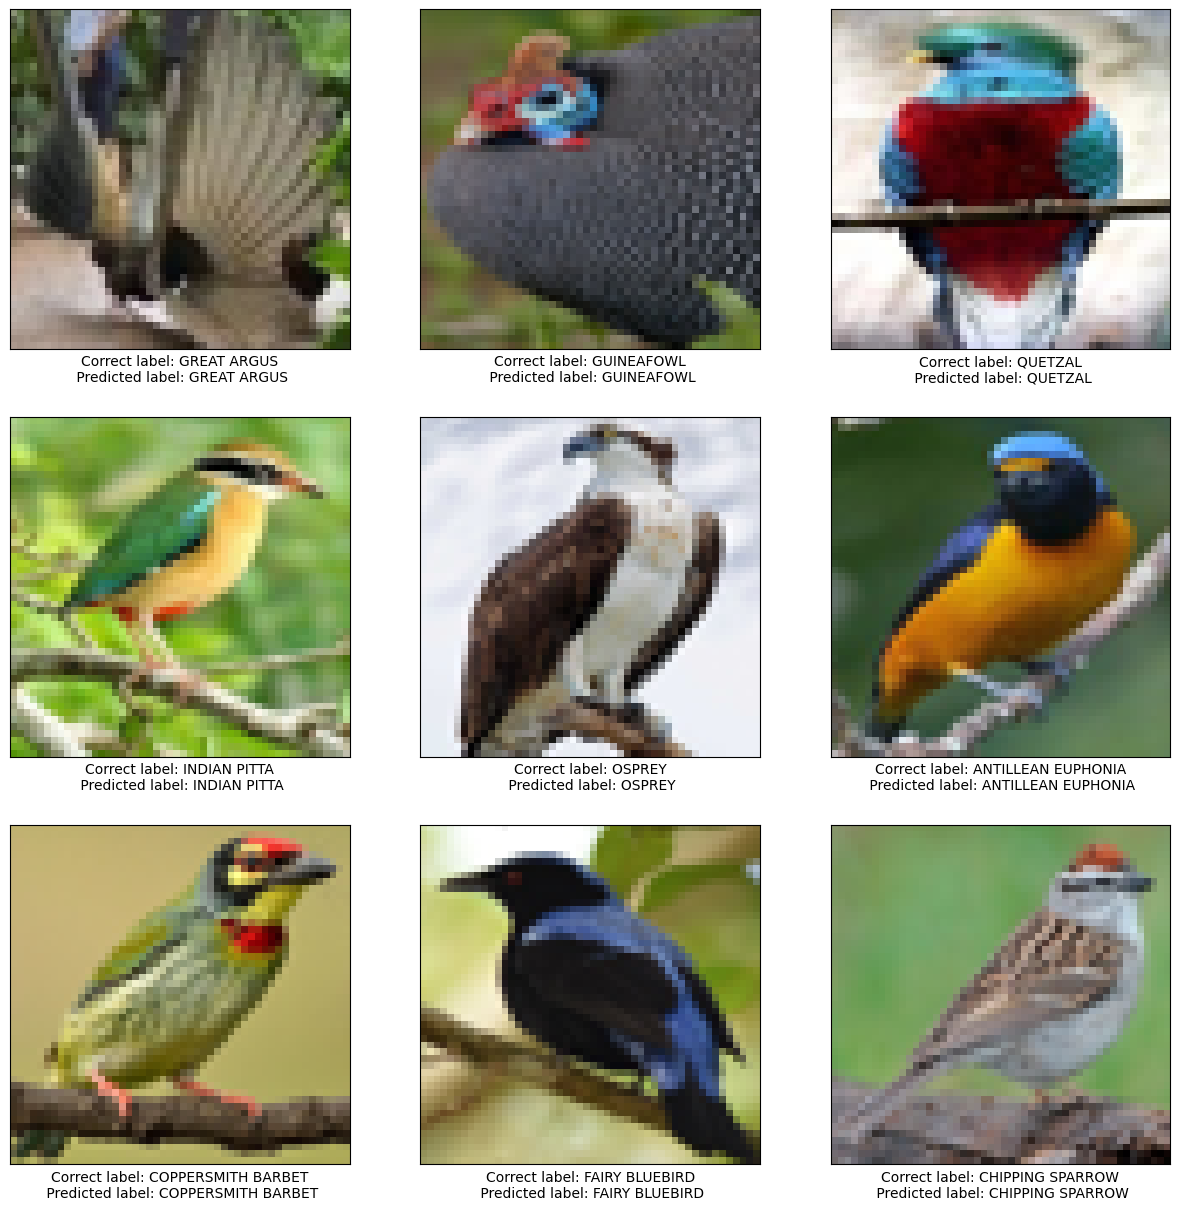

In [ ]:
import random
from PIL import Image
# Tomamos fotos aleatorias del dataset
pics = []
labels = [x for x in train_dataset.class_indices]
print(len(labels))
for i in range(9):
  dir = random.choice(os.listdir("test"))
  pics.append(("test/"+dir+"/"+random.choice(os.listdir("test/"+dir)),
               dir))
#print(pics)
plt.figure(figsize = (15,15))
i=0
for image, label in pics:
  img = Image.open(image)
  predimg = img.resize((224,224))
  predimg = np.array(predimg)
  predimg = predimg/255
  predimg = predimg.reshape(1,224,224,3)
  prediction = model.predict(predimg)
  predicted_label = np.argmax(prediction)
  #print(predicted_label)
  #print(predicted_label)
  img = img.resize((50,50))
  img = np.array(img)
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img)
  plt.xlabel("Correct label: " +label+"\n Predicted label: "+labels[predicted_label])
  i+=1
plt.show()